In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import pandas as pd

In [8]:
milk = pd.read_csv('milk.csv', index_col = 'Month')

In [9]:
milk.head(3)

,Monthly milk production (pounds per cow)
Month,
1962-01,589
1962-02,561
1962-03,640


In [10]:
# Make the index a time series

milk.index = pd.to_datetime(milk.index)

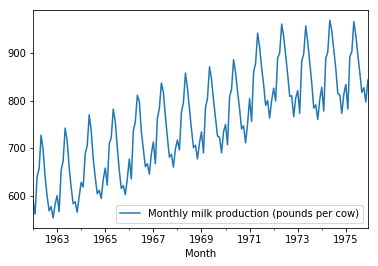

In [11]:
# Plot out the time series
milk.plot()

### lest attempt to predict a year worth of data or (12 steps into future)

In [12]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Monthly milk production (pounds per cow)    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


In [13]:
#train test split
train_set = milk.head(156)
test_set = milk.tail(12)

In [15]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
#batch function to feed data as batch

def next_batch(training_data, batch_size, steps):
    '''
    INPUT : Data,Batch Size, Time Step Per Batch
    O/P : A tuple of y time series result. y[:,:-1] and y[:,1:]
    '''
    #use random to set a random starting point index for the batch
    #remember that each epochs need have the same no. of step in it
    #this means you should limit the starting point to len(data) - steps
    rand_start = np.random.randint(0, len(training_data)-steps)
    
    #now that you have a starting index you'll need to index the data form
    #the random start + steps + 1. Then reshape data to be (1, steps+1)
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    #Return the batch, You'll have two batches to return y[:,:-1] and y[:,1:]
    #and need to reshape these into tensor for rnn to reshape(-1,steps,1)
    return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1,steps,1)
    
    

In [17]:
#setting up rnn

#constants
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.03
num_training_iteration = 4000
batch_size = 1

In [18]:
x=tf.placeholder(tf.float32,[None, num_time_steps,num_inputs]) #None cause will be return by batch
y=tf.placeholder(tf.float32,[None, num_time_steps,num_outputs])

In [19]:
#RNN cell layer
cell = tf.contrib.rnn.BasicLSTMCell(num_units = num_neurons, activation = tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size = num_outputs)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [20]:
#perform fully dynamic unrolling of inputs
output, states = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [22]:
#MSE
loss = tf.reduce_mean(tf.square(output-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [23]:
init = tf.global_variables_initializer()

In [24]:
saver = tf.train.Saver()

In [26]:
#sess
#with tf.Session(config = tf.COnfigProto(gpu_options = gpu_options)) as sess:
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_training_iteration):
        x_batch, y_batch = next_batch(train_scaled, batch_size, num_time_steps)
        sess.run(train, feed_dict = {x:x_batch, y:y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            print(iteration, '\tMSE', mse)
    saver.save(sess,'./milk_saved_model')

0 	MSE 0.09843712
100 	MSE 0.008603186
200 	MSE 0.011951129
300 	MSE 0.009419616
400 	MSE 0.013218825
500 	MSE 0.011464673
600 	MSE 0.008821918
700 	MSE 0.00877382
800 	MSE 0.004279263
900 	MSE 0.008207901
1000 	MSE 0.012195564
1100 	MSE 0.012998414
1200 	MSE 0.0107958885
1300 	MSE 0.0052644047
1400 	MSE 0.007664107
1500 	MSE 0.006034525
1600 	MSE 0.006828278
1700 	MSE 0.0062664333
1800 	MSE 0.0074845334
1900 	MSE 0.0057384945
2000 	MSE 0.00528102
2100 	MSE 0.0019694127
2200 	MSE 0.0053930427
2300 	MSE 0.0040364238
2400 	MSE 0.007173255
2500 	MSE 0.0036990754
2600 	MSE 0.0031382106
2700 	MSE 0.012483518
2800 	MSE 0.0036344007
2900 	MSE 0.0060086134
3000 	MSE 0.0022149796
3100 	MSE 0.0023916594
3200 	MSE 0.0036901908
3300 	MSE 0.00095281686
3400 	MSE 0.005521387
3500 	MSE 0.004324317
3600 	MSE 0.0066011674
3700 	MSE 0.005542493
3800 	MSE 0.0024677922
3900 	MSE 0.004117129


In [28]:
#Predicting the future
test_set

,Monthly milk production (pounds per cow)
Month,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817


In [29]:
#Generative Session
with tf.Session() as sess:
    saver.restore(sess, './milk_saved_model')
    
    train_seed = list(train_scaled[-12:])
    for iteration in range(12): #because i want 12 month
        x_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(output, feed_dict={x:x_batch})
        train_seed.append(y_pred[0,-1,0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./milk_saved_model


In [30]:
#show result of prediction
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.65464246,
 0.5699618,
 0.8158032,
 0.8387791,
 1.0172995,
 1.026545,
 0.9626452,
 0.871362,
 0.77569115,
 0.69135976,
 0.6059851,
 0.5786027]

- grab the portion of the result that are generated value and apply inverse_transform on them to turn them back into milk production value units. Also reshape the result to be 12,1 so we can easily add them to the test set df.

- inverse cause as the result above the tail 12 are still not scaled

In [32]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

- create a new column on the test set called generated and set it equal to the generated result.

In [33]:
test_set['Generated'] = results

C:\Users\codehax41\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
test_set

,Monthly milk production (pounds per cow),Generated
Month,,
1975-01-01,834,825.331238
1975-02-01,782,790.104065
1975-03-01,892,892.374146
1975-04-01,903,901.932129
1975-05-01,966,976.196655
1975-06-01,937,980.042725
1975-07-01,896,953.460449
1975-08-01,858,915.486572
1975-09-01,817,875.687561


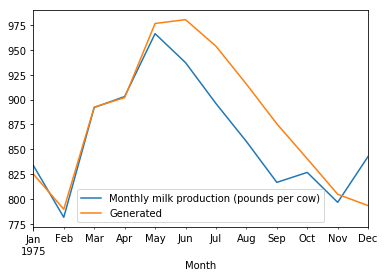

In [36]:
#plot 
test_set.plot()

In [ ]:
#Try another cells and Play with different hyperparameters